# Segmenting Cardiomyoctye Model Parameters

### *Personal Note*

*The data and analysis included here was part of a project where I evaluated predictions of cardiomyocyte action potential models. The objective here is to separate different hypotheses from a population of models. Additionally, I review some different clustering stratagies. The model features have biophysical and physiological meaning, but I will put a principal component step in as well. The data set is the output from training multiple independent populations of models using evolutionary algorithms. I hope you find it interesting.*

## Introduction

The cardiac action potential (AP) is the electrical waveform that is conducted through individual cells during a cardiac cycle. Cardiac electrophysiology is a complex system consisting of electrically active proteins, organelles, and tonal signalling molecules that work in conjuction to produce the AP. Each singular cell expresses different quantities of each active component, which will influence the risk of an arrhythmia occurance. It is quite challenging to determine the component quanties in individual cells, so it is useful to train AP models on data sets collected from specific cells to estimate these quantities. The cardiomyocyte model trained is the Kernik-Clancy iPSC model [DOI: 10.1113/JP277724](https://doi.org/10.1113/jp277724). I used an evolutionary algorithm (EA) to optimize 14 parameters and pooled the best performing models into a single dataset. The tuned parameters are scalars for sarcolemmal currents, so they scale the current densities and have no units. In this analysis I am going to use clustering algorithms to segment the proposed solutions from the EA.

   Let's look at the data!

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet, fcluster
from scipy.spatial.distance import pdist

%matplotlib inline

In [2]:
# The data set should be mostly cleaned-up
c5_params = pd.read_csv('./c5_EA_params_20220222.txt', delimiter=' ')
c5_params.head()

,phi,G_K1,G_Kr,G_Ks,G_to,P_CaL,G_CaT,G_Na,G_F,K_NaCa,P_NaK,G_b_Na,G_b_Ca,G_PCa,fitness
0,0.775628,0.675315,2.650434,4.334555,9.196563e-03,0.288796,0.389463,0.335001,1.512508,2.888285,0.391604,0.035992,0.586479,0.609346,132.473587
1,0.775628,0.675315,2.650434,4.334555,2.450242e-02,0.292615,0.419559,0.349077,1.596385,2.992886,0.438024,0.035335,0.526647,0.609346,133.175263
2,0.775628,0.675315,2.650434,4.334555,1.432695e-02,0.293383,0.406567,0.335001,1.512135,2.901646,0.370172,0.035933,0.496448,0.609346,133.427304
3,0.775628,0.254140,2.650434,4.334555,8.637277e-17,0.315902,0.475337,0.310485,1.703607,2.998820,0.408051,0.020221,0.154906,0.748181,133.932624
4,0.775628,0.675315,2.640649,4.850079,5.976922e-02,0.305420,0.500353,0.341133,1.579939,2.898543,0.324433,0.025676,0.168743,0.734143,135.369830


### *Observations and a brief introduction to evolutionary algorithms*

There are serveral things to point out here that will help build an understanting of the data. The first 5 values of the variable *phi* ($\phi$) are identical and 4/5 of the *G_K1* values are also identical. This individual similarity is true for the other variables as well, and is typical from optimizations using evolutionary algorithms. As the name of the algorithm implies, EAs select the most fit individuals to reproduce and populate the next generation, so as generations proceed certain values propagate. EAs are robust and generic optimizers that are only contrained to the domain objective through the cost function. I implemented an EA here because after the generational evaluation there isn't a need for additional simulations. Most mechanistic cardiomyocyte models are compuationally expensive to run and require the numerical integrator to use small time steps. The last column named *fitness* is the result of evaluating the cost function and we will exclude it while clustering.

*Let's start with some preprocessing.*

In [3]:
"""The parameters span are expressed in linear scale for the simulation,
but are quantities being modeled are distributed on the logarithmic scale. Since the data is in R^14 space
I like to calculate the distance from the origin for visualization purposes."""

# Drop fitness
fitness = c5_params.fitness
c5_params.drop(labels=['fitness'], axis=1, inplace=True)

# Log and standardize
scaler = StandardScaler()
sc_params = scaler.fit_transform(np.log(c5_params))

# Distance from origin
dist_origin = ((sc_params*sc_params).sum(axis=1))**0.5

## Hierarchical Clustering

In cluster analysis problems determining the number of clusters is a central question. There are many algorithms that can be choosen that will group the data differently, but what is 'correct' is sometimes difficult to determine. The data set here is not too large, so I am going start by applying hierarchical clustering and making a dendrogram. I like that hierarchical clustering is deterministic, produces an appealing visualization, and doesn't require the number of clusters to be predetermined. Additionally, it works thematically with analyzing EA optimized models. The hierarchical method used here is an agglomerative type.

In [4]:
"""There are 14 features and the distance measurement I am using is the standardized-log Euclidean distance.
The merging criterion is the Ward's minimum variance."""
Z = linkage(sc_params, 'ward')
Z[:5]

array([[3.07000000e+02, 3.08000000e+02, 2.01227923e-15, 2.00000000e+00],
       [8.20000000e+01, 8.30000000e+01, 4.91336635e-03, 2.00000000e+00],
       [3.09000000e+02, 3.10000000e+02, 1.08469511e-02, 2.00000000e+00],
       [3.13000000e+02, 1.02400000e+03, 1.75525222e-02, 3.00000000e+00],
       [4.86000000e+02, 4.88000000e+02, 1.85121013e-02, 2.00000000e+00]])

The *linkage()* function returns Z-matrix containing the distances and linkages between the points. Briefly in each row: the first two columns are the indices of the data points, the third column is the calculated distance between them, and the last is count of data points that are contained after the points are merged. Before we jump in and plot the dendrogram, let's take a quick look at the distribution of calculated distances.

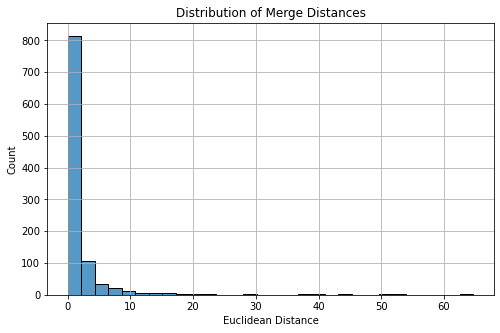

In [5]:
# Get distances
coph_dists = Z[:,2]

# Plot histogram
plt.figure(figsize=(8,5))
sns.histplot(coph_dists, bins=30)
plt.title('Distribution of Merge Distances')
plt.xlabel('Euclidean Distance')
plt.grid(True)
plt.show()

These intermediate plots help remind me what is being calculated. This distribution shows that there were many short-distance merges and then a steep drop-off and few long-distance merges. This plot indicates that the calculation worked, but cannot indicate that the clusters are well fit.

The cophenetic correlation coefficient calculates the correlation between the merge distances and the pairwise distances.

In [6]:
# Calculate c
c, coph_dists = cophenet(Z, pdist(sc_params))
print(f'Cophenentic Coeff: {round(c, 5)}')

# Print Last 10 merge distances
print(f'Last 10 Merges: {Z[-10:,2]}')

Cophenentic Coeff: 0.42985
Last 10 Merges: [22.73601639 29.76609019 29.98886932 37.38609647 39.26524788 40.24168985
 45.06013172 51.53842946 53.01326516 64.6827849 ]


There is some correlation, but not strong correlation. There are probably some noticable clusters in the dendrogram. The distances of the last 3 merges (51.5, 53.0, 64.7) don't show huge jumps, so it might indicate that some points are not clearly separated.

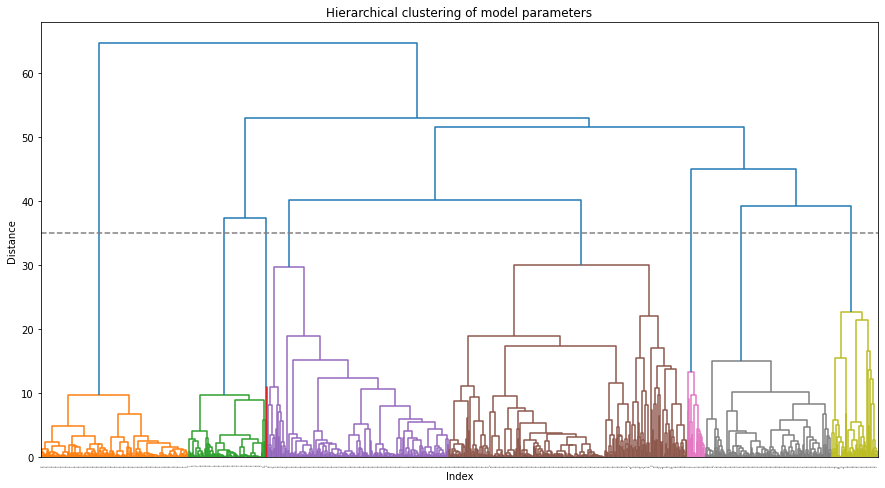

In [7]:
# Plot the Dendrogram
plt.figure(figsize=(15,8))
plt.title('Hierarchical clustering of model parameters')
plt.xlabel('Index')
plt.ylabel('Distance')
plt.tick_params(labelbottom = False)
dendrogram(Z, leaf_font_size=0, color_threshold=35)
plt.axhline(y=35, linestyle='dashed', color='grey')
plt.show()

Kind of messy, the purple and brown clusters seem to add more data with consistent distances. The color cutoff at 35 is where I would manually choose to segment the models and I would end up 8 hypothese to evaluate. Let's check if the *elbow* method will give any insight into how many clusters to include.

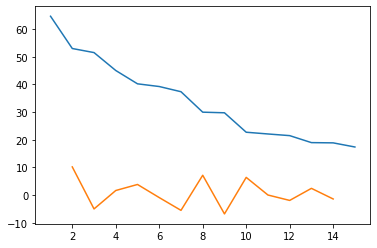

Clusters: 2


In [8]:
# Create merge indices
idxs = np.arange(1, len(Z[-15:,2]) + 1)
# Calculate merge length acceleration
acc = np.diff(Z[-15:,2][::-1], 2)
# Plot acceleration and merge lengths
plt.plot(idxs, Z[-15:,2][::-1])
plt.plot(idxs[:-2] + 1, acc)
plt.show()
# Print max acc
print(f'Clusters: {acc.argmax()+2}')

The maximum distance acceleration occured at the final step, and if we look back at the dendrogram the models would segment into the orange cluster and then everything else. There could be many reasons that the clusters were not well identified. I suspect that the higher dimensionality (14 parameters) and low observations cause the data to become sparse. I think that there are more than 2 clusters, so I am going manually set the cut off at a distance of 35. Another take away from the hierarchical clustering is that there is a fair amount of noise in the data indicated by merging of clusters at regular distance intervals. Density-based spatial clustering can identify noise, so let's store the previous cluster assignments and try it next.

In [9]:
# Using the max distance of 35 as the clustering criteria
h_clusters = fcluster(Z, 35, criterion='distance')

In [57]:
h_clusters_2 = fcluster(Z, 55, criterion='distance')

## Density Based Clustering

Cardiomyoctyes (really all biological systems) are complex causing the modeling of emergent properties such as the action potential difficult. One aspect I have found fascinating in modeling biophysical systems, is that the systems have robustness and the ability accomidate variation. The implementation of the EA did not constrain the range of each parameter. The resulting data set likely has introduced noise because some parameters were less critical in the EA training set. *DBSCAN* from *scikit-learn* clusters points based on the data density. There are many tutorials that explain the algorithm, so I am only going to briefly introduced the two hyperparameters. The first hyperparameter is *epsilon or eps* ($\epsilon$) which sets the distance at which data points are considered to be neighboring. The second hyperparameter is *min_samples* which sets the number of points need to classify a point as a *core* point. Core points have the minimumn number of neighboring points within the volume with the radius $\epsilon$.

### Selecting *min_samples* and creating a k-distance plot

In [73]:
neighbors = NearestNeighbors(n_neighbors=14)
neighbors_fit = neighbors.fit(sc_params)
dists, indices = neighbors_fit.kneighbors(sc_params)

In [74]:
dists[:5]

array([[ 0.        ,  0.2722409 ,  0.51424209,  0.92286771,  1.12231855,
         1.24292458,  1.28607009,  1.31708203,  1.32122497,  1.32351071,
         1.32755511,  1.34348344,  1.37510271,  1.37686567],
       [ 0.        ,  0.35577319,  0.51424209,  0.55373807,  1.08727769,
         1.09443876,  1.10327605,  1.11201114,  1.1251976 ,  1.13034689,
         1.13883829,  1.15377558,  1.15599941,  1.16610969],
       [ 0.        ,  0.2722409 ,  0.35577319,  0.6876918 ,  0.9915332 ,
         1.08958346,  1.0949133 ,  1.11241301,  1.12018472,  1.12621417,
         1.13304056,  1.13475258,  1.14279396,  1.16542322],
       [ 0.        ,  5.54234784,  7.13339959, 14.02465552, 14.5719562 ,
        15.02838729, 15.03097198, 15.09435236, 15.24182845, 15.33831038,
        15.37658941, 15.38424473, 15.39675977, 15.58115163],
       [ 0.        ,  0.36189774,  0.46185232,  0.4674631 ,  0.49439991,
         0.49869623,  0.54696036,  0.56800939,  0.587429  ,  0.62101003,
         0.66370884,  0.66

In [75]:
dists = np.sort(dists, axis=0)

array([[0.00000000e+00, 2.01227923e-15, 1.42746558e-02, ...,
        1.71754996e-01, 1.76322536e-01, 1.96401842e-01],
       [0.00000000e+00, 2.01227923e-15, 1.78100794e-02, ...,
        1.73979120e-01, 1.79861485e-01, 2.03099487e-01],
       [0.00000000e+00, 4.91336635e-03, 1.78100794e-02, ...,
        1.78048094e-01, 1.83445086e-01, 2.03413239e-01],
       ...,
       [0.00000000e+00, 7.63488901e+00, 1.13055068e+01, ...,
        1.25917005e+01, 1.26002073e+01, 1.26868998e+01],
       [0.00000000e+00, 1.09281809e+01, 1.15125320e+01, ...,
        1.53842447e+01, 1.53967598e+01, 1.55811516e+01],
       [0.00000000e+00, 1.14847777e+01, 1.19546645e+01, ...,
        2.03041991e+01, 2.03432111e+01, 2.05121945e+01]])

In [79]:
dists_k_14 = np.sort(dists[:,-1])

In [80]:
dists_k_14[:5]

array([0.19640184, 0.20309949, 0.20341324, 0.20992434, 0.21264485])

In [81]:
kl = KneeLocator(np.arange(len(dists_k_14)), dists_k_14, curve='convex', direction='increasing')

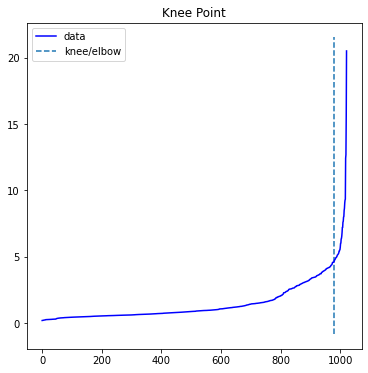

In [82]:
kl.plot_knee()

In [83]:
kl.knee_y

4.586781959542069

In [42]:
pdists = pd.DataFrame(pdist(sc_params))

In [46]:
pdists.describe()

,0
count,5.217310e+05
mean,4.755651e+00
std,2.326202e+00
min,2.012279e-15
25%,3.555409e+00
50%,4.443605e+00
75%,5.644711e+00
max,2.661814e+01


In [72]:
np.sort?

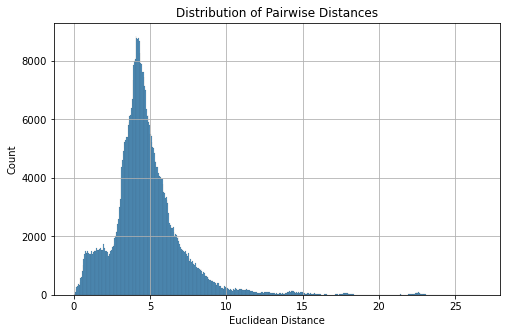

In [23]:
# Plot histogram
plt.figure(figsize=(8,5))
sns.histplot(pdist(sc_params))
plt.title('Distribution of Pairwise Distances')
plt.xlabel('Euclidean Distance')
plt.grid(True)
plt.show()

In [84]:
dbscan = DBSCAN(eps=kl.knee_y, min_samples = 14)

In [85]:
db_clusters = dbscan.fit_predict(sc_params)

In [86]:
db_clusters.shape

(1022,)

In [87]:
label, counts = np.unique(db_clusters, return_counts=True)

In [88]:
label

array([-1,  0,  1])

In [89]:
counts

array([ 23, 980,  19])

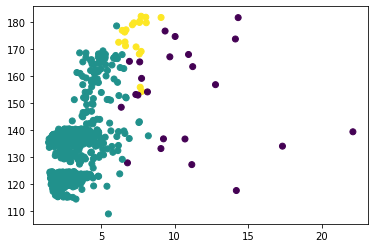

In [90]:
plt.scatter(dist_origin, fitness, c=db_clusters)
plt.show()

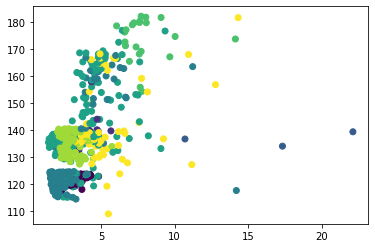

In [56]:
plt.scatter(dist_origin, fitness, c=h_clusters)
plt.show()

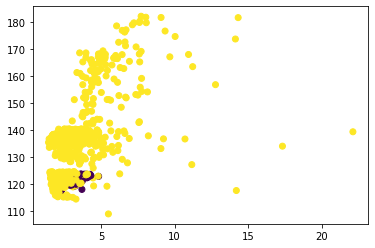

In [58]:
plt.scatter(dist_origin, fitness, c=h_clusters_2)
plt.show()